In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, Markdown
from collections import Counter
import random
from lightgbm import LGBMClassifier

from golemai.dataset.custom_column_selectors import ProportionAggSelector, JensenShannonSelector
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

In [2]:
EXP_NAME_CONTEXT = 'window_step_1__on_context__all__agg_weighted_llama2'

In [3]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\hallu_project\\Research\\notebooks'

In [4]:
context_df = None

for f_ in os.listdir(os.path.join("..", "..", EXP_NAME_CONTEXT)):
        
    if f_.startswith('attension'):

        if context_df is None:
            context_df = pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))
        else:
            context_df = pd.concat((context_df, pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))))

context_df = context_df.dropna()

In [5]:
N_LAYERS = 32
N_HEADS = 32

In [6]:

context_df.columns = [
    f'layer_{i}_head_{j}' for i in range(N_LAYERS) for j in range(N_HEADS)
] + [
    'context_perc', 'label', 'dataset', 'example_name'
]

In [7]:
context_df = context_df.loc[context_df['dataset'].isin(['nq', 'cnndm'])]

In [8]:
context_df['dataset'].value_counts()

dataset
nq       102109
cnndm     57922
Name: count, dtype: int64

In [9]:
context_df['context_perc_scaler'] = 1 / context_df['context_perc'] ** (1 / 2)

In [10]:
context_df[[col for col in context_df.columns if 'layer' in col]] = context_df[[col for col in context_df.columns if 'layer' in col]].multiply(context_df['context_perc_scaler'], axis=0)

In [ ]:
context_df.head()

,layer_0_head_0,layer_0_head_1,layer_0_head_2,layer_0_head_3,layer_0_head_4,layer_0_head_5,layer_0_head_6,layer_0_head_7,layer_0_head_8,layer_0_head_9,...,layer_31_head_27,layer_31_head_28,layer_31_head_29,layer_31_head_30,layer_31_head_31,context_perc,label,dataset,example_name,context_perc_scaler
0,0.862583,0.950571,0.955657,0.607267,0.913443,0.955148,0.937347,0.972949,0.880384,0.970915,...,0.067389,0.477828,0.124607,0.225436,0.037159,0.9217,0,nq,"nq_0.npy__(0, 8)",1.041610
1,0.895377,0.952864,0.953881,0.597257,0.911656,0.957951,0.928445,0.972196,0.916744,0.970670,...,0.075484,0.468292,0.124259,0.246992,0.041526,0.9212,0,nq,"nq_0.npy__(1, 9)",1.041893
2,0.894973,0.947498,0.951068,0.545653,0.899053,0.954128,0.922510,0.966877,0.911801,0.959227,...,0.085864,0.423518,0.162803,0.323822,0.047840,0.9168,0,nq,"nq_0.npy__(10, 18)",1.044390
3,0.888586,0.943166,0.951327,0.540191,0.896747,0.952348,0.932454,0.967140,0.904399,0.957959,...,0.076642,0.411392,0.174580,0.344314,0.045398,0.9163,0,nq,"nq_0.npy__(11, 19)",1.044675
4,0.887808,0.940872,0.951077,0.537787,0.894441,0.953118,0.932198,0.966894,0.901584,0.958730,...,0.060814,0.452578,0.191848,0.428597,0.054563,0.9158,0,nq,"nq_0.npy__(12, 20)",1.044960


In [12]:
context_perc = context_df['context_perc']
example_name = context_df['example_name']

In [13]:
context_df = context_df.drop(columns=['context_perc', 'context_perc_scaler', 'example_name'])

In [14]:
def train_and_eval(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    model: Pipeline,
):
    
    model.fit(X_train, y_train)

    train_pred = model.predict_proba(X_train)
    auc_train = roc_auc_score(y_train, train_pred[:, 1])

    val_pred = model.predict_proba(X_val)
    auc_val = roc_auc_score(y_val, val_pred[:, 1])

    test_pred = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, test_pred[:, 1])

    if 'coef_' in dir(model.named_steps['model']):
        feature_importance = model.named_steps['model'].coef_[0]
    else:
        feature_importance = model.named_steps['model'].feature_importances_

    return {
        'train_auc': auc_train,
        'val_auc': auc_val,
        'test_auc': auc_test,
        'feature_importance': feature_importance,
        'val_preds': val_pred,
        'test_preds': test_pred
    }

In [15]:
def train_model(
        context_df: pd.DataFrame, 
        models: dict,
        use_cv: bool = True,
        features: list = None
    ):

    validation_results = []
    feature_importances = {}
    preds = {}

    # Loop over each unique dataset
    for dataset in context_df['dataset'].unique():

        in_dist_sample = context_df.loc[context_df['dataset'] != dataset]
        out_dist_sample = context_df.loc[context_df['dataset'] == dataset]

        feature_importances[dataset] = []
        preds[dataset] = {}

        for model_name in models.keys():

            X_train, X_test = in_dist_sample.drop(columns=['label', 'dataset']), out_dist_sample.drop(columns=['label', 'dataset'])

            if features is not None:
                X_train, X_test = X_train[features], X_test[features]

            y_train, y_test = in_dist_sample['label'], out_dist_sample['label']

            aucs_train, aucs_val, aucs_test = [], [], []

            if use_cv:
                
                skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

                for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
                    
                    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
                    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

                    model = clone(models[model_name])

                    result = train_and_eval(X_tr, y_tr, X_val, y_val, X_test, y_test, model)

                    feature_importances[dataset].append(result['feature_importance'])

                    aucs_train.append(result['train_auc'])
                    aucs_val.append(result['val_auc'])
                    aucs_test.append(result['test_auc'])

                    print(f'Fold: {i} Dataset: {dataset}, Model: {model_name}, Train AUC: {result["train_auc"]}, Val AUC: {result["val_auc"]}, Test AUC: {result["test_auc"]}')

            else:

                model = clone(models[model_name])

                result = train_and_eval(X_train, y_train, X_train, y_train, X_test, y_test, model)
                feature_importances[dataset].append(result['feature_importance'])

                preds[dataset] = {
                    'val': result['val_preds'],
                    'test': result['test_preds']
                }

                aucs_train.append(result['train_auc'])
                aucs_val.append(result['val_auc'])
                aucs_test.append(result['test_auc'])

            train_auc = np.mean(aucs_train)
            auc_val = np.mean(aucs_val)
            auc_test = np.mean(aucs_test)

            print(f'Dataset: {dataset}, Model: {model_name}, Train AUC: {train_auc}, Val AUC: {auc_val}, Test AUC: {auc_test}')

            # Store the result
            validation_results.append({
                'dataset': dataset,
                'columns_selection': model.named_steps['selector'].__class__.__name__ if 'selector' in model.named_steps else 'all',
                'model': model_name,
                'train_auc': train_auc,
                'val_auc': auc_val,
                'test_auc': auc_test
            })

    return {
        'validation_results': pd.DataFrame(validation_results),
        'feature_importances': feature_importances,
        'preds': preds
    }

In [16]:
import pandas as pd

def calculate_median_diff(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the median of heads per layer and the difference between each head and the median.
    
    Args:
        df: DataFrame with columns named 'layer_{n}_head_{m}'
    
    Returns:
        DataFrame with new features representing the difference between each head and the median of its layer
    """
    # Extract layer and head information
    layer_head_cols = [col for col in df.columns if col.startswith('layer_')]
    layer_head_df = df[layer_head_cols]
    
    # Create a multi-index for easier aggregation
    layer_head_df.columns = pd.MultiIndex.from_tuples(
        [(int(col.split('_')[1]), int(col.split('_')[3])) for col in layer_head_cols],
        names=['layer', 'head']
    )
    
    # Calculate median per layer
    layer_medians = layer_head_df.groupby(level='layer', axis=1).median()
    
    # Broadcast the median values to match the original DataFrame shape
    layer_medians_broadcasted = layer_medians.reindex(layer_head_df.columns, level='layer', axis=1)
    
    # Calculate the difference between each head and the median of its layer
    diff_df = (layer_head_df - layer_medians_broadcasted).abs()

    del layer_head_df
    
    # Flatten the multi-index columns
    diff_df.columns = [f'layer_{layer}_head_{head}_diff' for layer, head in diff_df.columns]
    
    return diff_df

In [18]:
def random_undersample(X, y):
    return RandomUnderSampler(random_state=42).fit_resample(X, y)

In [19]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
}

In [20]:
models = {
    'logistic_reg_js': Pipeline(
        [
            # ('selector', JensenShannonSelector(n_features=25)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', MinMaxScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [21]:
diff_df = calculate_median_diff(context_df)
diff_df['label'] = context_df['label']
diff_df['dataset'] = context_df['dataset']

C:\Users\Piotr.Matys\AppData\Local\Temp\ipykernel_4464\3372772006.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diff_df['label'] = context_df['label']
C:\Users\Piotr.Matys\AppData\Local\Temp\ipykernel_4464\3372772006.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diff_df['dataset'] = context_df['dataset']


In [55]:
TOP_N = 10

layer_head_cols = [col for col in diff_df.columns if col.startswith('layer_')]
layer_head_df = diff_df[layer_head_cols]

layer_head_df.columns = pd.MultiIndex.from_tuples(
    [(int(col.split('_')[1]), int(col.split('_')[3])) for col in layer_head_cols],
    names=['layer', 'head']
)

most_diff = np.zeros((layer_head_df.shape[0], TOP_N * 32))
unique_layers = layer_head_df.columns.get_level_values('layer').unique()
num_layers = len(unique_layers)

for i, layer in enumerate(unique_layers):

    layer_diff = layer_head_df.xs(layer, level='layer', axis=1).to_numpy()
    top_diff_values = np.sort(layer_diff, axis=1)[:, -TOP_N:]

    idx_start = i * TOP_N
    idx_end = idx_start + TOP_N

    most_diff[:, idx_start: idx_end] = top_diff_values

diff_df_most = pd.DataFrame(most_diff, columns=[f'layer_{i}_diff_top_{j}' for i in range(num_layers) for j in range(TOP_N, 0, -1)])

In [56]:
diff_df_most['label'] = context_df['label'].values
diff_df_most['dataset'] = context_df['dataset'].values

In [57]:
np.random.seed(42)
context_df['random_feature'] = np.random.rand(context_df.shape[0])
diff_df['random_feature'] = np.random.rand(diff_df.shape[0])
diff_df_most['random_feature'] = np.random.rand(diff_df_most.shape[0])

In [58]:
results = train_model(
    context_df=diff_df_most,
    models=models,
    features=None,
    use_cv=True
)

Fold: 0 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8471821150713951, Val AUC: 0.8131219582409137, Test AUC: 0.619277910591185
Fold: 1 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8393862118556512, Val AUC: 0.8218994703294885, Test AUC: 0.6302745992675585
Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8432841634635231, Val AUC: 0.8175107142852012, Test AUC: 0.6247762549293717
Fold: 0 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7721627251987008, Val AUC: 0.765240608814808, Test AUC: 0.6167506646684746
Fold: 1 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7734112308559697, Val AUC: 0.7633009169122381, Test AUC: 0.6360242194459778
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7727869780273353, Val AUC: 0.764270762863523, Test AUC: 0.6263874420572262


In [59]:
feature_importances = results['feature_importances']

In [60]:
train_cols = diff_df_most.drop(columns=['label', 'dataset']).columns

nq_f_im = np.stack(feature_importances['nq'])
cnndm_f_im = np.stack(feature_importances['cnndm'])

nq_f_im = np.mean(nq_f_im, axis=0)
cnndm_f_im = np.mean(cnndm_f_im, axis=0)

nq_f_im_df = pd.DataFrame(nq_f_im, index=train_cols, columns=['nq'])
cnndm_f_im_df = pd.DataFrame(cnndm_f_im, index=train_cols, columns=['cnndm'])

nq_th = np.abs(nq_f_im_df.loc['random_feature', 'nq'])
cnndm_th = np.abs(cnndm_f_im_df.loc['random_feature', 'cnndm'])

nq_f_im_df = nq_f_im_df.loc[np.abs(nq_f_im_df['nq']) > nq_th]
cnndm_f_im_df = cnndm_f_im_df.loc[np.abs(cnndm_f_im_df['cnndm']) > cnndm_th]

nq_f_im_df = nq_f_im_df.sort_values('nq', ascending=False)
cnndm_f_im_df = cnndm_f_im_df.sort_values('cnndm', ascending=False)

above_randomness_features = set(nq_f_im_df.index.to_list()) & set(cnndm_f_im_df.index.to_list())

In [61]:
len(above_randomness_features)

306

In [62]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'C': 0.1
}

models = {
    'logistic_reg_js': Pipeline(
        [
           # ('selector', JensenShannonSelector(n_features=200)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

results = train_model(
    context_df=diff_df_most,
    models=models,
    features=list(above_randomness_features),
    use_cv=True
)

Fold: 0 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8464446306021224, Val AUC: 0.8140143315533725, Test AUC: 0.6203047950278806
Fold: 1 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8388185850234949, Val AUC: 0.8227432253682072, Test AUC: 0.629934100789146
Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8426316078128087, Val AUC: 0.8183787784607899, Test AUC: 0.6251194479085134
Fold: 0 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7715957528822814, Val AUC: 0.7648839738563785, Test AUC: 0.6169030142749656
Fold: 1 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7729256522544837, Val AUC: 0.7630018628293813, Test AUC: 0.6365753969558783
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7722607025683825, Val AUC: 0.7639429183428799, Test AUC: 0.626739205615422


In [63]:
random_values_context = np.random.randint(100, 500, size=10)
random_values_gen = np.random.randint(6, 200, size=10)

mock_at = [
    np.random.random(size=(32, 32, rvc, rgg)) for rvc, rgg in zip(random_values_context, random_values_gen)
]

In [64]:
mock_at

[array([[[[0.80183292, 0.77229939, 0.84145322, ..., 0.45368105,
           0.60993372, 0.20150033],
          [0.86603579, 0.01198228, 0.08385625, ..., 0.6458442 ,
           0.71612261, 0.18125466],
          [0.56988068, 0.02206656, 0.09712578, ..., 0.81705464,
           0.27522706, 0.65811112],
          ...,
          [0.46478683, 0.68742118, 0.77428891, ..., 0.72989218,
           0.05589923, 0.16249433],
          [0.98743734, 0.25923665, 0.89664067, ..., 0.41307848,
           0.43895331, 0.53371604],
          [0.11806883, 0.41083843, 0.66969592, ..., 0.32024242,
           0.89256243, 0.01788564]],
 
         [[0.43010654, 0.93064098, 0.79027532, ..., 0.45020892,
           0.93283071, 0.19021367],
          [0.45167526, 0.06939088, 0.39996309, ..., 0.01198317,
           0.61855704, 0.76684396],
          [0.2030372 , 0.763115  , 0.08543182, ..., 0.15881832,
           0.25534724, 0.64976372],
          ...,
          [0.33510843, 0.09458896, 0.35392638, ..., 0.54535952,
   

In [94]:
results['validation_results']

,dataset,columns_selection,model,train_auc,val_auc,test_auc
0,nq,all,logistic_reg_js,0.963461,0.963461,0.660264
1,cnndm,all,logistic_reg_js,0.881600,0.881600,0.673742


### Influence of window's position

In [89]:
analize_df = pd.DataFrame(
    {
        'dataset': context_df['dataset'],
        'label': context_df['label'],
        'test_pred': None,
        'example_name': example_name,
        'context_perc': context_perc
    }
)

In [90]:
analize_df.loc[analize_df['dataset'] == 'nq', 'test_pred'] = results['preds']['nq']['test'][:, 1]
analize_df.loc[analize_df['dataset'] == 'cnndm', 'test_pred'] = results['preds']['cnndm']['test'][:, 1]

analize_df[['start_window_idx', 'end_window_idx']] = analize_df['example_name'].str.extract(r'\((\d+), (\d+)\)')
analize_df['start_window_idx'] = analize_df['start_window_idx'].fillna('0').astype(int)
analize_df['end_window_idx'] = analize_df['end_window_idx'].fillna('8').astype(int)

analize_df['test_pred'] = analize_df['test_pred'].astype(float)

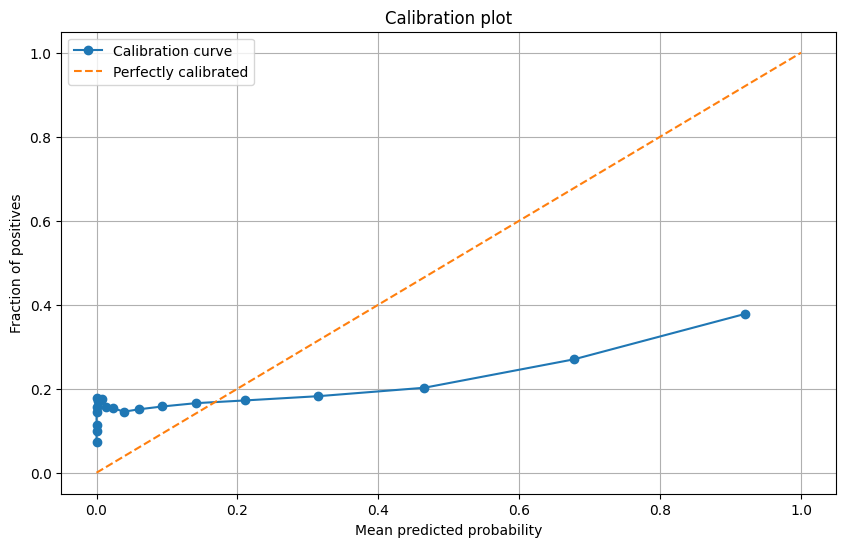

In [91]:
from sklearn.calibration import calibration_curve

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(analize_df['label'], analize_df['test_pred'], n_bins=20, strategy='quantile')

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.grid()
plt.show()

In [92]:
from sklearn.metrics import roc_auc_score

groups = [
    (0, 16),
    (16, 32),
    (32, 64),
    (64, 250)
]

# Calculate AUC for each group
auc_results = {}

for dataset in analize_df['dataset'].unique():

    auc_results[dataset] = {}

    for start, end in groups:

        group_df = analize_df[(analize_df['start_window_idx'] >= start) & (analize_df['end_window_idx'] <= end) & (analize_df['dataset'] == dataset)]

        if not group_df.empty:
            auc = roc_auc_score(group_df['label'], group_df['test_pred'])
            auc_results[dataset][f'{start}-{end}'] = {
                'perc': group_df.shape[0] / analize_df.loc[analize_df['dataset'] == dataset].shape[0] * 100,
                'auc': auc
            }

In [93]:
from IPython.display import display, Markdown

for ds in auc_results.keys():
    display(Markdown(f'### {ds}'))
    display(pd.DataFrame(auc_results[ds]).T.round(3))

### nq

,perc,auc
0-16,14.617,0.698
16-32,11.093,0.637
32-64,19.227,0.611
64-250,33.196,0.629


### cnndm

,perc,auc
0-16,15.523,0.642
16-32,15.511,0.627
32-64,32.905,0.631
64-250,7.527,0.791


### Superior performance for `cnndm` for **64-250** and better performance for short answers for `nq`

In [37]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'solver': 'saga',
    'penalty': 'l2',
    'C': 1
}

models = {
    'logistic_reg_js': Pipeline(
        [
            # ('selector', JensenShannonSelector(n_features=25)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [ ]:
results = train_model(
    context_df=context_df,
    models=models,
    features=list(above_randomness_features),
    use_cv=False
)

In [118]:
nq_f_im = np.stack(feature_importances['nq'])
cnndm_f_im = np.stack(feature_importances['cnndm'])

nq_f_im = np.mean(nq_f_im, axis=0)
cnndm_f_im = np.mean(cnndm_f_im, axis=0)

nq_f_im_df = pd.DataFrame(nq_f_im, index=list(above_randomness_features), columns=['nq'])
cnndm_f_im_df = pd.DataFrame(cnndm_f_im, index=list(above_randomness_features), columns=['cnndm'])

nq_f_im_df = nq_f_im_df[np.abs(nq_f_im_df['nq']) >= 0.02]
cnndm_f_im_df = cnndm_f_im_df[cnndm_f_im_df['cnndm'] >= 0.02]

after_sec_filter = set(nq_f_im_df.index.to_list()) & set(cnndm_f_im_df.index.to_list())

In [181]:
N_FEATURES = 5

In [190]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'solver': 'saga',
    'penalty': None
}

lgbm_config = {
    'n_estimators': 250,
    'learning_rate': 0.001,
    'max_depth': 10,
    'num_leaves': 15,
    'random_state': 42,
    'n_jobs': -1,
    'silent': True,
    'verbose': -1,
    'class_weight': 'balanced'
}

models = {
    'logistic_reg_js': Pipeline(
        [
            ('selector', JensenShannonSelector(n_features=N_FEATURES)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [184]:
res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7392819162151598, Val AUC: 0.7277230364965053, Test AUC: 0.5009861710714885

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7314776031178991, Val AUC: 0.744619600635356, Test AUC: 0.5868057919786902

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7353797596665295, Val AUC: 0.7361713185659307, Test AUC: 0.5438959815250893
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6779892636502367, Val AUC: 0.6819429506219994, Test AUC: 0.67499825963021

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6833087977575582, Val AUC: 0.6773445477303291, Test AUC: 0.6798860014308823

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6806490307038975, Val AUC: 0.6796437491761642, Test AUC: 0.6774421305305461


In [185]:
res['validation_results']

,dataset,columns_selection,model,train_auc,val_auc,test_auc
0,nq,JensenShannonSelector,logistic_reg_js,0.735380,0.736171,0.543896
1,cnndm,JensenShannonSelector,logistic_reg_js,0.680649,0.679644,0.677442


### It is possible to train a model on `5` features and achieve a better performacne than on all features for `nq` -> `cnndm` dataset. However, the performance on `cnndm` -> `nq` dataset is much worse. For fist fold is random

In [188]:
N_FEATURES = 250

models = {
    'logistic_reg_js': Pipeline(
        [
            ('selector', ProportionAggSelector(n_features=N_FEATURES)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.895635696271276, Val AUC: 0.8781402325294562, Test AUC: 0.6591268150674006

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8926729073756088, Val AUC: 0.882996038034515, Test AUC: 0.6607932872742314

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8941543018234424, Val AUC: 0.8805681352819856, Test AUC: 0.6599600511708159
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.795135551656357, Val AUC: 0.7871823934262917, Test AUC: 0.6699162173061397

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7951285584431538, Val AUC: 0.7870955590380773, Test AUC: 0.6627963421466072

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7951320550497554, Val AUC: 0.7871389762321845, Test AUC: 0.6663562797263735


In [189]:
res['validation_results']

,dataset,columns_selection,model,train_auc,val_auc,test_auc
0,nq,ProportionAggSelector,logistic_reg_js,0.894154,0.880568,0.659960
1,cnndm,ProportionAggSelector,logistic_reg_js,0.795132,0.787139,0.666356


### On `250` features it is possible to match paper performance (or even exceed it, because of inproperly validated test set in LL)

In [196]:
lgbm_config = {
    'n_estimators': 500,
    'learning_rate': 0.0005,
    'max_depth': 10,
    'num_leaves': 15,
    'random_state': 42,
    'n_jobs': -1,
    'silent': True,
    'verbose': -1,
    'class_weight': 'balanced'
}

models = {
    'lgbm_all_no_sampler': Pipeline(
        [
            ('model', LGBMClassifier(
                **lgbm_config
            )),
        ]
    ),
}

res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8359108496790965, Val AUC: 0.7903515741211375, Test AUC: 0.5895834508941947

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8247507784369899, Val AUC: 0.8080718998018563, Test AUC: 0.5847259566955414

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8303308140580432, Val AUC: 0.7992117369614969, Test AUC: 0.5871547037948681
Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7485059315678595, Val AUC: 0.7399587211455776, Test AUC: 0.6940646978060581

Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7478055080578498, Val AUC: 0.7321240544599947, Test AUC: 0.7113845962702108

Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7481557198128547, Val AUC: 0.7360413878027862, Test AUC: 0.7027246470381344


In [197]:
res['validation_results']

,dataset,columns_selection,model,train_auc,val_auc,test_auc
0,nq,all,lgbm_all_no_sampler,0.830331,0.799212,0.587155
1,cnndm,all,lgbm_all_no_sampler,0.748156,0.736041,0.702725


### On `nq` -> `cnndm` 0.7 AUC can be exceeded using `LGBM`, but it performes poorly on `cnndm` -> `nq` dataset. And it can be seen that the model overfits only a little bit, which means a decent generalization.